# Inverse folding - folding Scores and figures
## Define some functions

In [1]:
import pandas as pd
from pathlib import Path
import json
import seaborn as sns
import matplotlib.pyplot as plt
from Levenshtein import distance
import matplotlib
import matplotlib.patches as  mpatches
import numpy as np
from Bio import PDB

parent_path = Path("/data/jgut/msa-tests")
df = pd.read_csv(parent_path/"porter_data.csv", header=None)
pd.set_option('display.max_columns', None)

def get_plddts(file_name):
    parser = PDB.PDBParser(PERMISSIVE=1, QUIET=True)
    structure = parser.get_structure("1CUR",file_name)
    model = next(iter(structure))
    chain = next(iter(model))
    plddts = []
    for residue in chain:
        plddts.append(float(next(iter(residue)).get_bfactor()))
    return sum(plddts)/len(plddts)

def open_ost(ost_path:Path):
    if not ost_path.exists():
        return -1, -1, -1, -1, -1, -1 ,-1, -1
    with open(ost_path) as json_data:
        score_json = json.load(json_data)
    if score_json["status"] != "SUCCESS":
        return -1, -1, -1, -1, -1, -1 ,-1, -1
    lddt = score_json["lddt"] if "lddt" in score_json else 0
    bb_lddt = score_json["bb_lddt"] if "bb_lddt" in score_json else 0
    tm_score = score_json["tm_score"] if "tm_score" in score_json else 0
    inconsistent_residues = score_json["inconsistent_residues"] if "inconsistent_residues" in score_json else -1
    length = len(score_json["local_lddt"]) if "local_lddt" in score_json else -1
    model_bad_bonds = len(score_json["reference_bad_bonds"]) if "reference_bad_bonds" in score_json else -1
    model_bad_angles = len(score_json["reference_bad_angles"]) if "reference_bad_angles" in score_json else -1
    if not "reference" in score_json.keys():
        print(ost_path)
        print(score_json)
    ref_path = score_json["reference"].replace("/ibmm_data/","/data/").replace("/data/jgut/msa-tests/porter_all_models/", "/data/jgut/msa-tests/aaa_porter_all_models/porter_all_models/")
    plddt = get_plddts(ref_path)
    return lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt

def open_secstruc(secstruc_path:Path):
    if not secstruc_path.exists():
        return None, None, -1, -1, -1, -1
    with open(secstruc_path) as json_data:
        json_dict = json.load(json_data)
    secstruc_string = "".join(json_dict["secstruc"])
    sequence_string = "".join(json_dict["residues"])
    gap_total = json_dict["-_total"]
    gap_relative = json_dict["-_rel"]
    return secstruc_string, sequence_string, len(secstruc_string), len(sequence_string), gap_total, gap_relative

def find_match(row, df, matches, success_cat):
    curr_struc = row["struc"]
    other_struc = matches[curr_struc]
    other_success = df[(df["struc"]==other_struc) & (df["MSA"]==row["MSA"]) & (df["Model"]==row["Model"])][["Model","MSA","struc",success_cat]].groupby("struc").agg("max")[success_cat]
    if other_success.any():
        return row[success_cat] and other_success.item()
    return False

In [2]:
scores = []
for it, row in list(df.iterrows()):
    struc_a = row[0]
    struc_b = row[1]
    case_name = struc_a+struc_b
    case_path = parent_path/"aaa_porter_all_models/porter_all_models"/case_name
    for comparison in [struc_a, struc_b]:
        #full_path = list(case_path.glob(f"{comparison}*_sec_struc.json"))[0]
        #full_secstruc_string, full_sequence_string, full_len_secstruc_string, full_len_sequence_string, full_gap_total, full_gap_relative = open_secstruc(full_path)
        _, _, _, _, gap_total, gap_relative = open_secstruc(case_path/f"{comparison}_full_sec_struc.json")
        for cluster_dir in (case_path/f"{comparison}_clusters").glob(f"{comparison}_*_cut"):
            cluster_num = int(str(cluster_dir)[-7:-4])
            if cluster_num<50:
                for file_path in cluster_dir.glob("*score_A.json"):
                    lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(file_path)
                    if lddt>0:
                        rank = int(str(file_path).split("rank_")[1][0:3])
                        model = int(str(file_path).split("_model_")[1][0])
                        curr_entry = {"struc":struc_a, "Model rank":rank, "Model number":model, "lDDT": lddt, "pLDDT":plddt, "BB-lDDT":bb_lddt,  "TM-score": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "MSA":"MMseqs2", "Model":"AlphaFold2 Cluster", "-_total":gap_total , "-_rel":gap_relative}
                        scores.append(curr_entry)
                for file_path in cluster_dir.glob("*score_B.json"):
                    lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(file_path)
                    if lddt>0:
                        rank = int(str(file_path).split("rank_")[1][0:3])
                        model = int(str(file_path).split("_model_")[1][0])
                        curr_entry = {"struc":struc_b, "Model rank":rank, "Model number":model, "lDDT": lddt,"pLDDT":plddt,"BB-lDDT":bb_lddt,  "TM-score": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "MSA":"MMseqs2", "Model":"AlphaFold2 Cluster", "-_total":gap_total , "-_rel":gap_relative}
                        scores.append(curr_entry)
        comparison_path = case_path/f"{comparison}_prot_dir_af3"
        for file_path in comparison_path.glob("*score.json"):
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(file_path)
            #curr_secstruc_string, curr_sequence_string, curr_len_secstruc_string, curr_len_sequence_string, curr_gap_total, curr_gap_relative = 
            if lddt>0:
                rank = 6 #int(str(file_path).split("rank_")[1][0:3])
                model = int(str(file_path).split("-it-")[1][0])+1
                curr_entry = {"struc":comparison, "Model rank":rank, "Model number":model, "lDDT": lddt,"pLDDT":plddt,"BB-lDDT":bb_lddt, "TM-score": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "MSA":"Synthetic", "Model":"AlphaFold 3", "-_total":gap_total , "-_rel":gap_relative}
                scores.append(curr_entry)
        comparison_path = case_path/f"{comparison}_prot_dir"
        for file_path in comparison_path.glob("*score.json"):
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(file_path)
            #curr_secstruc_string, curr_sequence_string, curr_len_secstruc_string, curr_len_sequence_string, curr_gap_total, curr_gap_relative = open_secstruc(Path(str(file_path)[:-len("score.json")]+"sec_struc.json"))
            if lddt>0:
                rank = int(str(file_path).split("rank_")[1][0:3])
                model = int(str(file_path).split("_model_")[1][0])
                curr_entry = {"struc":comparison, "Model rank":rank, "Model number":model, "lDDT": lddt,"pLDDT":plddt,"BB-lDDT":bb_lddt, "TM-score": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "MSA":"Synthetic", "Model":"AlphaFold 2", "-_total":gap_total , "-_rel":gap_relative}
                #levenshtein = distance(full_secstruc_string, curr_secstruc_string)
                #curr_entry = curr_entry | {"full_secstruc_string":full_secstruc_string, "full_sequence_string":full_sequence_string, "full_len_secstruc_string": full_len_secstruc_string, "full_len_sequence_string":full_len_sequence_string, "full_gap_total": full_gap_total, "full_gap_relative":full_gap_relative,"levenshtein": levenshtein,"levenshtein_ratio":levenshtein/full_len_sequence_string, "curr_secstruc_string":curr_secstruc_string, "curr_sequence_string":curr_sequence_string, "curr_len_secstruc_string": curr_len_secstruc_string, "curr_len_sequence_string":curr_len_sequence_string, "curr_gap_total": curr_gap_total, "curr_gap_relative":curr_gap_relative}
                scores.append(curr_entry)
        comparison_packed = case_path/f"{comparison}_score_dir_af3_nat"
        for file_path in comparison_packed.glob("*score.json"):
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(file_path)
            if lddt>0:
                rank = 6 #int(str(file_path).split("rank_")[1][0:3])
                model = int(str(file_path).split("-it-")[1][0])+1
                curr_entry = {"struc":comparison, "Model rank":rank, "Model number":model, "lDDT": lddt,"pLDDT":plddt,"BB-lDDT":bb_lddt, "TM-score": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "MSA":"MMseqs2", "Model":"AlphaFold 3", "-_total":gap_total , "-_rel":gap_relative}
                scores.append(curr_entry)
        comparison_path = case_path/f"{comparison}_score_dir_af2_nat"
        for file_path in comparison_path.glob("1inp*score.json"):
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(file_path)
            #curr_secstruc_string, curr_sequence_string, curr_len_secstruc_string, curr_len_sequence_string, curr_gap_total, curr_gap_relative = open_secstruc(Path(str(file_path)[:-len("score.json")]+"sec_struc.json"))
            if lddt>0:
                rank = int(str(file_path).split("rank_")[1][0:3])
                model = int(str(file_path).split("_model_")[1][0])
                curr_entry = {"struc":comparison, "Model rank":rank, "Model number":model, "lDDT": lddt,"pLDDT":plddt,"BB-lDDT":bb_lddt, "TM-score": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "MSA":"MMseqs2", "Model":"AlphaFold 2", "-_total":gap_total , "-_rel":gap_relative}
                #levenshtein = distance(full_secstruc_string, curr_secstruc_string)
                #curr_entry = curr_entry | {"full_secstruc_string":full_secstruc_string, "full_sequence_string":full_sequence_string, "full_len_secstruc_string": full_len_secstruc_string, "full_len_sequence_string":full_len_sequence_string, "full_gap_total": full_gap_total, "full_gap_relative":full_gap_relative,"levenshtein": levenshtein,"levenshtein_ratio":levenshtein/full_len_sequence_string, "curr_secstruc_string":curr_secstruc_string, "curr_sequence_string":curr_sequence_string, "curr_len_secstruc_string": curr_len_secstruc_string, "curr_len_sequence_string":curr_len_sequence_string, "curr_gap_total": curr_gap_total, "curr_gap_relative":curr_gap_relative,}
                scores.append(curr_entry)
        comparison_path = case_path/f"score_{comparison}_diff"
        for file_path in comparison_path.glob("*score.json"):
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(file_path)
            #curr_secstruc_string, curr_sequence_string, curr_len_secstruc_string, curr_len_sequence_string, curr_gap_total, curr_gap_relative = open_secstruc(Path(str(file_path)[:-len("score.json")]+"sec_struc.json"))
            if lddt>0:
                rank = int(str(file_path).split("rank_")[1][0:3])
                model = int(str(file_path).split("_model_")[1][0])
                curr_entry = {"struc":comparison, "Model rank":rank, "Model number":model, "lDDT": lddt,"pLDDT":plddt,"BB-lDDT":bb_lddt, "TM-score": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "MSA":"Synthetic", "Model":"Remote homologs", "-_total":gap_total , "-_rel":gap_relative}
                #levenshtein = distance(full_secstruc_string, curr_secstruc_string)
                #curr_entry = curr_entry | {"full_secstruc_string":full_secstruc_string, "full_sequence_string":full_sequence_string, "full_len_secstruc_string": full_len_secstruc_string, "full_len_sequence_string":full_len_sequence_string, "full_gap_total": full_gap_total, "full_gap_relative":full_gap_relative,"levenshtein": levenshtein,"levenshtein_ratio":levenshtein/full_len_sequence_string, "curr_secstruc_string":curr_secstruc_string, "curr_sequence_string":curr_sequence_string, "curr_len_secstruc_string": curr_len_secstruc_string, "curr_len_sequence_string":curr_len_sequence_string, "curr_gap_total": curr_gap_total, "curr_gap_relative":curr_gap_relative}
                scores.append(curr_entry)
    lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(case_path/"score_AA_RF.json")
    if lddt>0:
        rank = 6
        model = 0
        curr_entry = {"struc":struc_a, "Model rank":rank, "Model number":model, "lDDT": lddt,"pLDDT":plddt,"BB-lDDT":bb_lddt, "TM-score": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "MSA":"MMseqs2", "Model":"RoseTTAFold2", "-_total":gap_total , "-_rel":gap_relative}
        scores.append(curr_entry)
    lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(case_path/"score_BB_RF.json")
    if lddt>0:
        rank = 6
        model = 0
        curr_entry = {"struc":struc_b, "Model rank":rank, "Model number":model, "lDDT": lddt,"pLDDT":plddt,"BB-lDDT":bb_lddt, "TM-score": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "MSA":"MMseqs2", "Model":"RoseTTAFold2", "-_total":gap_total , "-_rel":gap_relative}
        scores.append(curr_entry)
        
    lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(case_path/"score_Aprot_rf.json")
    if lddt>0:
        rank = 6
        model = 0
        curr_entry = {"struc":struc_a, "Model rank":rank, "Model number":model, "lDDT": lddt,"pLDDT":plddt,"BB-lDDT":bb_lddt, "TM-score": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "MSA":"Synthetic", "Model":"RoseTTAFold2", "-_total":gap_total , "-_rel":gap_relative}
        scores.append(curr_entry)
    lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, plddt = open_ost(case_path/"score_Bprot_rf.json")
    if lddt>0:
        rank = 6
        model = 0
        curr_entry = {"struc":struc_b, "Model rank":rank, "Model number":model, "lDDT": lddt,"pLDDT":plddt,"BB-lDDT":bb_lddt, "TM-score": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "MSA":"Synthetic", "Model":"RoseTTAFold2", "-_total":gap_total , "-_rel":gap_relative}
        scores.append(curr_entry)

## Missing cases

In [3]:
scores = pd.DataFrame(scores)
#sec_struc_df = pd.read_csv(parent_path/"sec_struc.csv")
#sec_struc_df["struc"] = sec_struc_df["pdb_path"].str.slice(18,23)
#sec_struc_df = sec_struc_df.set_index("struc")
#scores = scores.join(sec_struc_df[["-_total", "-_rel"]], on="struc")
all_strucs = [struc for struc in df[0]]+[struc for struc in df[1]]
for modeltype in scores["Model"].unique():
    for sequence_type in ["Synthetic", "MMseqs2"]:
        curr_strucs = scores[(scores["Model"]==modeltype)&(scores["MSA"]==sequence_type)].struc.unique()
        if len(curr_strucs)>3:
            print(f"{modeltype} {sequence_type} missing {len(set(all_strucs)-set(curr_strucs))}:{set(all_strucs)-set(curr_strucs)}")

AlphaFold2 Cluster MMseqs2 missing 0:set()
AlphaFold 3 Synthetic missing 0:set()
AlphaFold 3 MMseqs2 missing 0:set()
AlphaFold 2 Synthetic missing 0:set()
AlphaFold 2 MMseqs2 missing 0:set()
Remote homologs Synthetic missing 0:set()
RoseTTAFold2 Synthetic missing 0:set()
RoseTTAFold2 MMseqs2 missing 0:set()


## lDDT plots of all Models, best model
### Main plot

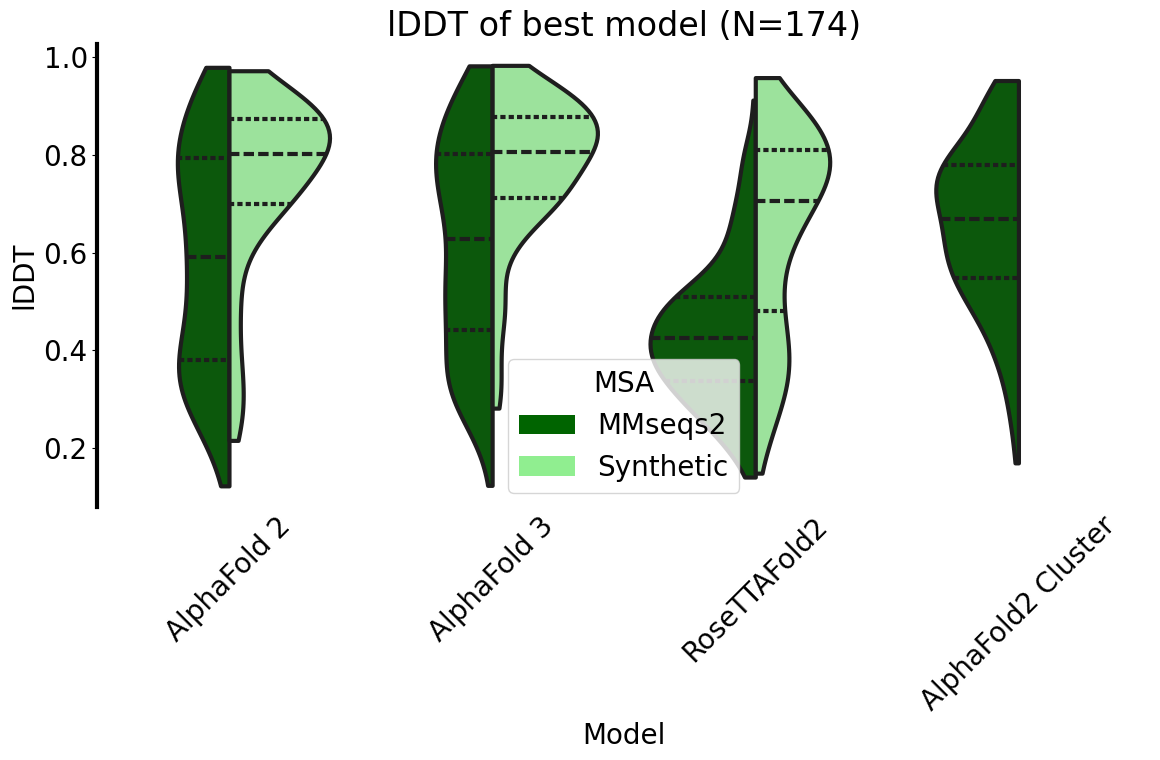

<Figure size 1200x800 with 0 Axes>

In [4]:
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.spines.bottom"] = False
matplotlib.rcParams["axes.spines.left"] = True
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams['font.size'] = 20
plt.setp(plt.gca().spines.values(), linewidth=3)
sns.violinplot(scores.groupby(["struc","Model", "MSA"]).agg("max"), x="Model", y="lDDT", hue="MSA", split=True, inner="quart", order=["AlphaFold 2", "AlphaFold 3", "RoseTTAFold2", "AlphaFold2 Cluster" ], palette=["#006400", "#90EE90"],cut=0, linewidth=3)
handles = [mpatches.Patch(facecolor="#006400", label="MMseqs2"), mpatches.Patch(facecolor="#90EE90", label="Synthetic")]
plt.legend(handles=handles, title="MSA")
plt.xticks(rotation=45)
plt.tick_params(axis=u'x', which=u'both',length=0)
plt.title(f"lDDT of best model (N={len(set(all_strucs))})")
plt.tight_layout()
plt.savefig("visualisations/lDDT_best_model.svg", format="svg", dpi=600, transparent=True)
plt.savefig("visualisations/lDDT_best_model.pdf", format="pdf", dpi=600, transparent=True)
plt.show()
plt.clf()

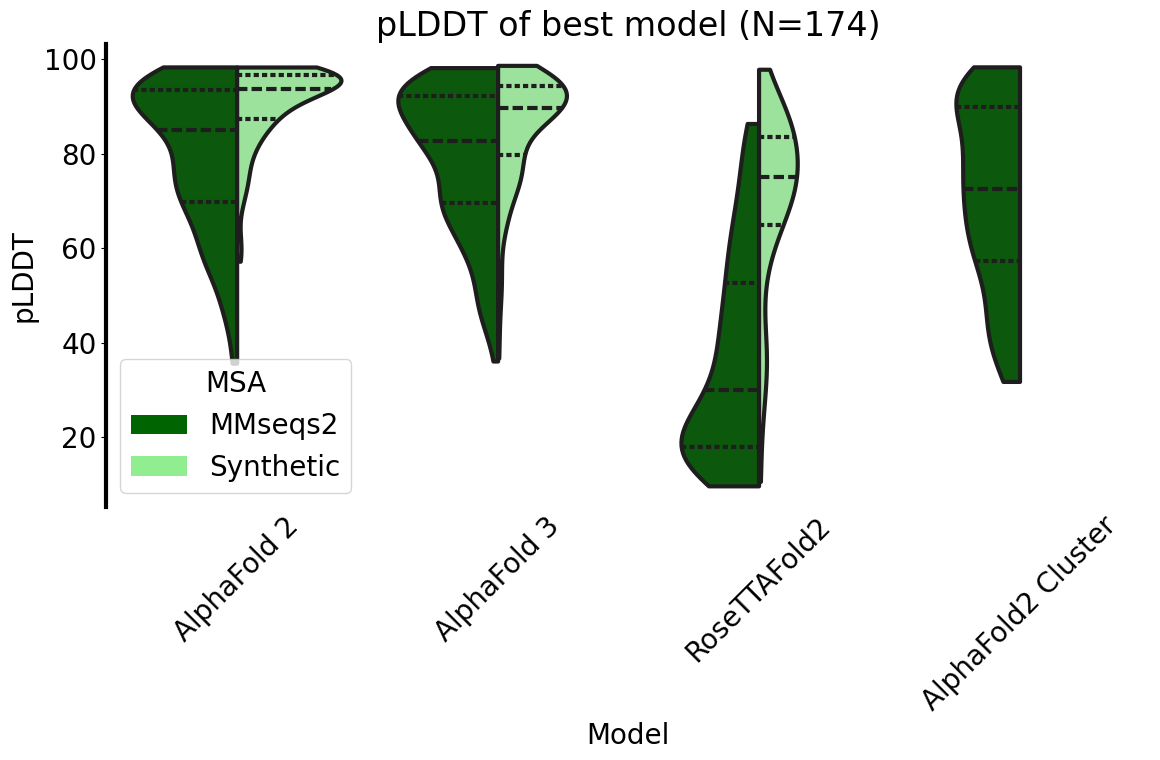

<Figure size 1200x800 with 0 Axes>

In [5]:
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.spines.bottom"] = False
matplotlib.rcParams["axes.spines.left"] = True
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams['font.size'] = 20
plt.setp(plt.gca().spines.values(), linewidth=3)
sns.violinplot(scores.groupby(["struc","Model", "MSA"]).agg("max"), x="Model", y="pLDDT", hue="MSA", split=True, inner="quart", order=["AlphaFold 2", "AlphaFold 3", "RoseTTAFold2", "AlphaFold2 Cluster" ], palette=["#006400", "#90EE90"],cut=0, linewidth=3)
handles = [mpatches.Patch(facecolor="#006400", label="MMseqs2"), mpatches.Patch(facecolor="#90EE90", label="Synthetic")]
plt.legend(handles=handles, title="MSA")
plt.xticks(rotation=45)
plt.tick_params(axis=u'x', which=u'both',length=0)
plt.title(f"pLDDT of best model (N={len(set(all_strucs))})")
plt.tight_layout()
plt.savefig("visualisations/pLDDT_best_model.svg", format="svg", dpi=600, transparent=True)
plt.savefig("visualisations/pLDDT_best_model.pdf", format="pdf", dpi=600, transparent=True)
plt.show()
plt.clf()

### Remote homologs plot

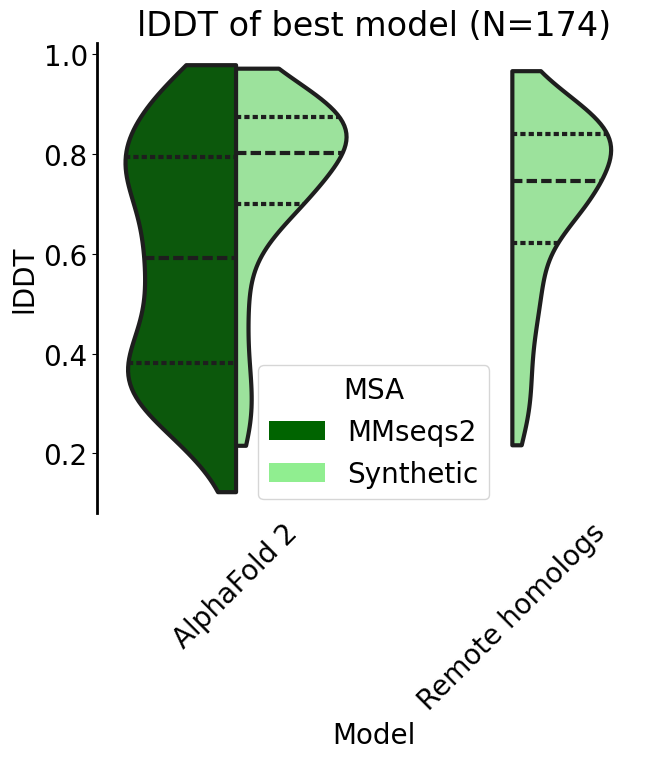

<Figure size 700x800 with 0 Axes>

In [6]:
plt.rcParams["figure.figsize"] = (7,8)
plt.setp(plt.gca().spines.values(), linewidth=2)
sns.violinplot(scores.groupby(["struc","Model", "MSA"]).agg("max"), x="Model", y="lDDT", hue="MSA", split=True, inner="quart", order=["AlphaFold 2", "Remote homologs" ], palette=["#006400", "#90EE90"],cut=0, linewidth=3)
handles = [mpatches.Patch(facecolor="#006400", label="MMseqs2"), mpatches.Patch(facecolor="#90EE90", label="Synthetic")]
plt.legend(handles=handles, title="MSA")
plt.xticks(rotation=45)
plt.tick_params(axis=u'x', which=u'both',length=0)
plt.title(f"lDDT of best model (N={len(set(all_strucs))})")
plt.tight_layout()
plt.savefig("visualisations/lDDT_remote_homologs.svg", format="svg", dpi=600, transparent=True)
plt.savefig("visualisations/lDDT_remote_homologs.pdf", format="pdf", dpi=600, transparent=True)
plt.show()
plt.clf()

## TM-score plots of all Models, best model
### Main plot

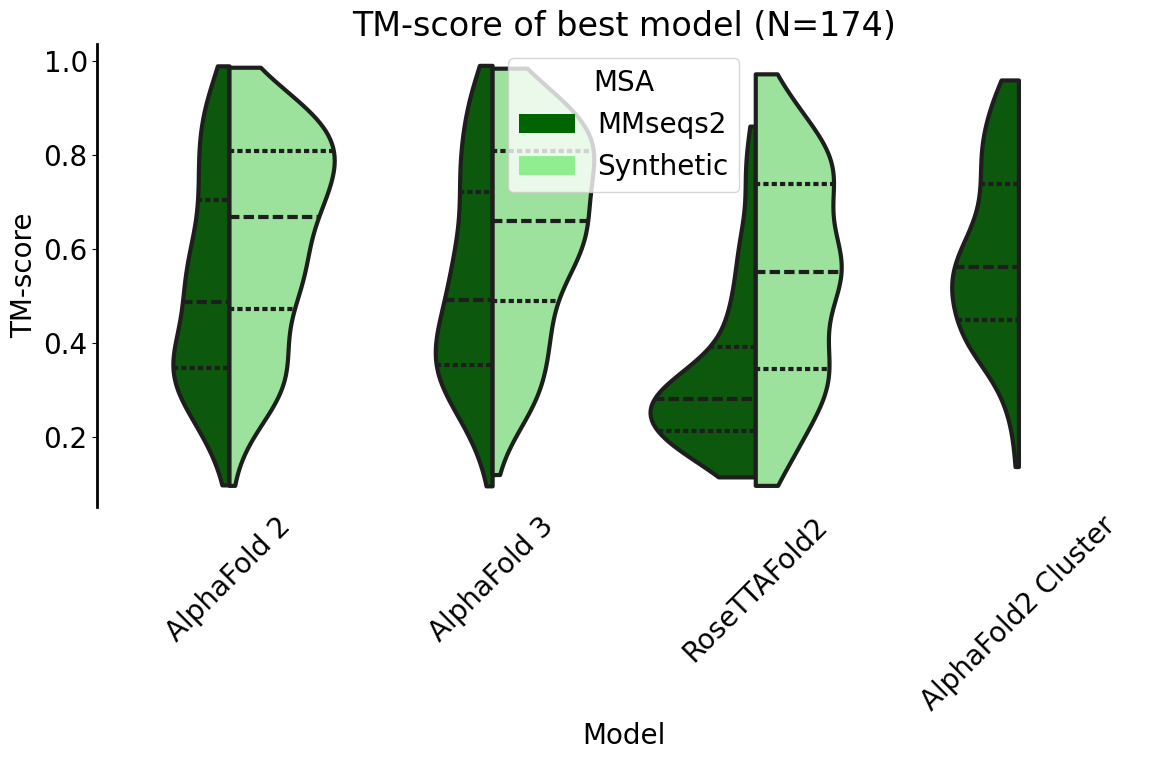

<Figure size 1200x800 with 0 Axes>

In [7]:
plt.rcParams["figure.figsize"] = (12,8)
plt.setp(plt.gca().spines.values(), linewidth=2)
sns.violinplot(scores.groupby(["struc","Model", "MSA"]).agg("max"), x="Model", y="TM-score", hue="MSA", split=True,cut=0, inner="quart", order=["AlphaFold 2", "AlphaFold 3", "RoseTTAFold2","AlphaFold2 Cluster" ], palette=["#006400", "#90EE90"], linewidth=3)
handles = [mpatches.Patch(facecolor="#006400", label="MMseqs2"), mpatches.Patch(facecolor="#90EE90", label="Synthetic")]
plt.legend(handles=handles, title="MSA")
plt.xticks(rotation=45)
plt.tick_params(axis=u'x', which=u'both',length=0)
plt.title(f"TM-score of best model (N={len(set(all_strucs))})")
plt.tight_layout()
plt.savefig("visualisations/TM_best_model.svg", format="svg", dpi=600, transparent=True)
plt.savefig("visualisations/TM_best_model.pdf", format="pdf", dpi=600, transparent=True)
plt.show()
plt.clf()

### Remote homologs plot

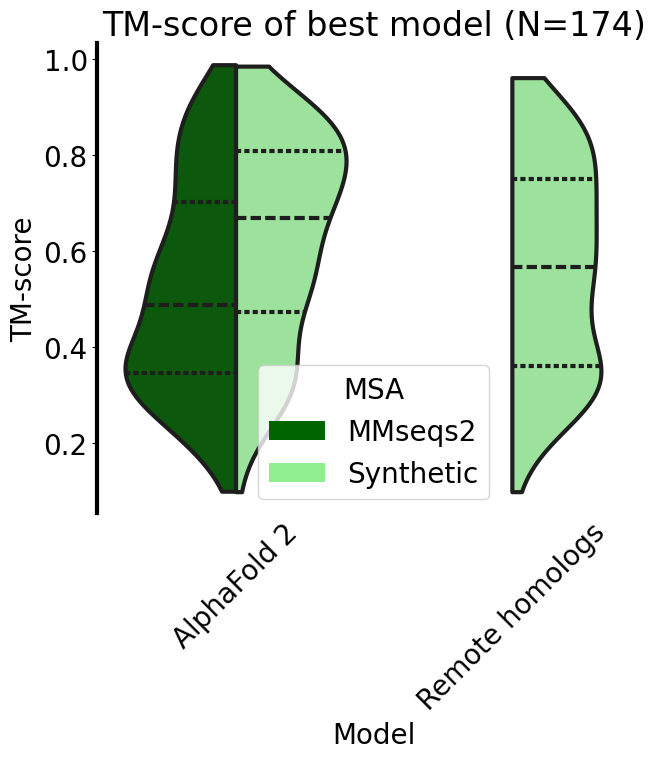

<Figure size 700x800 with 0 Axes>

In [8]:
plt.rcParams["figure.figsize"] = (7,8)
plt.setp(plt.gca().spines.values(), linewidth=3)

sns.violinplot(scores.groupby(["struc","Model", "MSA"]).agg("max"), x="Model", y="TM-score", hue="MSA", split=True, inner="quart", order=["AlphaFold 2", "Remote homologs"], palette=["#006400", "#90EE90"],cut=0, linewidth=3)
handles = [mpatches.Patch(facecolor="#006400", label="MMseqs2"), mpatches.Patch(facecolor="#90EE90", label="Synthetic")]
plt.legend(handles=handles, title="MSA")
plt.xticks(rotation=45)
plt.tick_params(axis=u'x', which=u'both',length=0)
plt.title(f"TM-score of best model (N={len(set(all_strucs))})")
plt.tight_layout()
plt.savefig("visualisations/TM_remote_homologs.svg", format="svg", dpi=600, transparent=True)
plt.show()
plt.clf()

## Check all conformations
Based on lDDT cut-off of 0.7

Plot sizing is off

We get 146/174.
MMseqs2 gets 98/174.
Together we get 150/174.


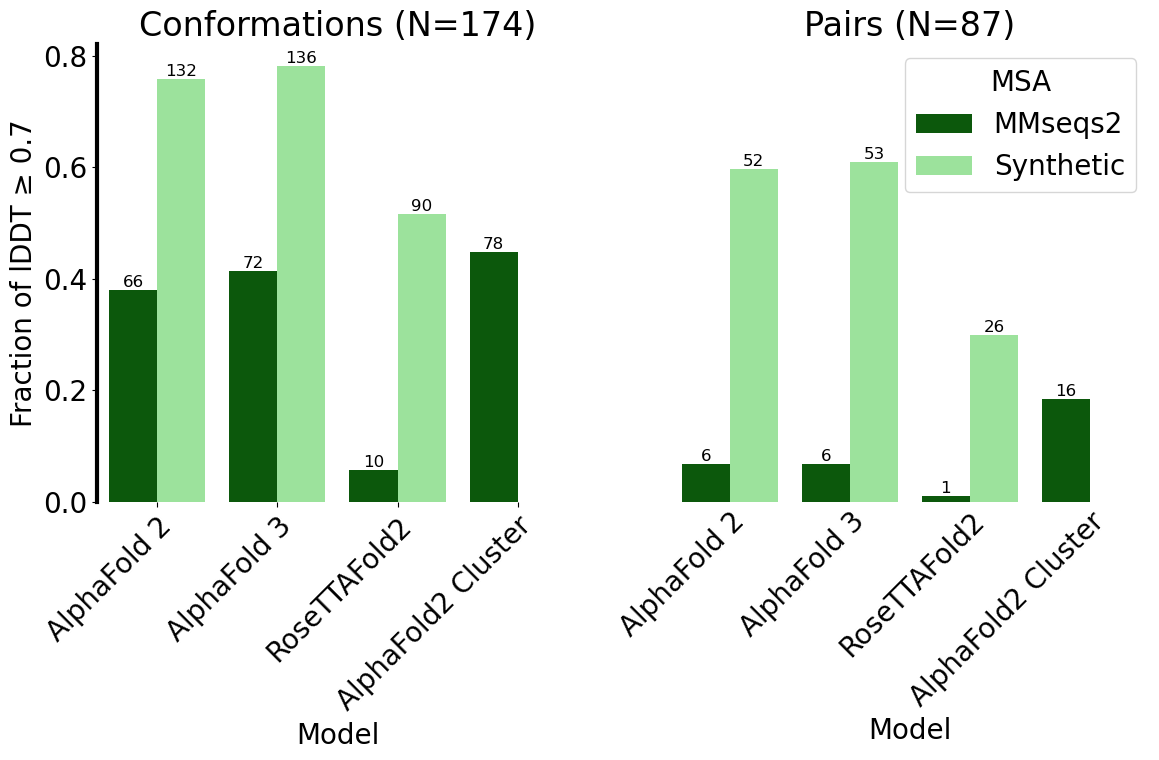

We get 62/87.0 pairs.
MMseqs2 gets 19/87.0 pairs.
Together we get 63/87.0 pairs.


<Figure size 1200x800 with 0 Axes>

In [9]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams['font.size'] = 20
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax1.spines.values(), linewidth=3)
ax1.spines[["left"]].set_visible(True)
scores["Fraction of lDDT ≥ 0.7"] = scores["lDDT"]>=0.7
sns.barplot(scores.groupby(["struc","MSA", "Model"]).agg("max"), x="Model", y="Fraction of lDDT ≥ 0.7", hue="MSA", errorbar=None,palette=["#006400", "#90EE90"], order=["AlphaFold 2", "AlphaFold 3", "RoseTTAFold2", "AlphaFold2 Cluster"],ax=ax1)
ax1.bar_label(ax1.containers[0],labels=[int(curr.get_height()*len(set(all_strucs))) for curr in ax1.containers[0]], fontsize=12)
ax1.bar_label(ax1.containers[1],labels=[int(curr.get_height()*len(set(all_strucs))) for curr in ax1.containers[1]], fontsize=12)
plt.tick_params(axis=u'x', which=u'both',length=0)
ax1.set_title(f"Conformations (N={len(set(all_strucs))})")
ax1.get_legend().remove()

print(f'We get {sum(scores[(scores["MSA"]=="Synthetic")][["MSA","struc","Fraction of lDDT ≥ 0.7"]].groupby(["struc","MSA"]).agg("max")["Fraction of lDDT ≥ 0.7"])}/{len(set(all_strucs))}.')
print(f'MMseqs2 gets {sum(scores[scores["MSA"]=="MMseqs2"].groupby(["struc","MSA"]).agg("max")["Fraction of lDDT ≥ 0.7"])}/{len(set(all_strucs))}.')
print(f'Together we get {sum(scores[["MSA","struc","Fraction of lDDT ≥ 0.7"]].groupby(["struc"]).agg("max")["Fraction of lDDT ≥ 0.7"])}/{len(set(all_strucs))}.')

matches = {row[1][0]: row[1][1] for row in df.iterrows()} | {row[1][1]: row[1][0] for row in df.iterrows()}
grouped = scores[["Model","MSA","struc","Fraction of lDDT ≥ 0.7"]].groupby(["struc","MSA", "Model"], as_index=False).agg("max")
grouped["Fraction of lDDT ≥ 0.7"] = [find_match(row[1], grouped, matches, "Fraction of lDDT ≥ 0.7")  for row in grouped.iterrows()]
sns.barplot(grouped.groupby(["struc","MSA", "Model"]).agg("max"), x="Model", y="Fraction of lDDT ≥ 0.7", errorbar=None, hue="MSA",palette=["#006400", "#90EE90"], order=["AlphaFold 2", "AlphaFold 3", "RoseTTAFold2","AlphaFold2 Cluster" ],ax=ax2)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax2.bar_label(ax2.containers[0],labels=[int(curr.get_height()*int(len(set(all_strucs))/2)) for curr in ax2.containers[0]], fontsize=12)
ax2.bar_label(ax2.containers[1],labels=[int(curr.get_height()*int(len(set(all_strucs))/2)) for curr in ax2.containers[1]], fontsize=12)
plt.xticks(rotation=45)
ax2.spines[['right', 'top', "left"]].set_visible(False)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title(f"Pairs (N={int(len(set(all_strucs))/2)})")
plt.tight_layout()
plt.savefig("visualisations/lDDT_accpeted.svg", format="svg", dpi=600, transparent=True)
plt.savefig("visualisations/lDDT_accpeted.pdf", format="pdf", dpi=600, transparent=True)

plt.show()
plt.clf()
print(f'We get {int(sum(grouped[grouped["MSA"]=="Synthetic"].groupby(["struc","MSA"]).agg("max")["Fraction of lDDT ≥ 0.7"])/2)}/{len(set(all_strucs))/2} pairs.')
print(f'MMseqs2 gets {int(sum(grouped[grouped["MSA"]=="MMseqs2"].groupby(["struc","MSA"]).agg("max")["Fraction of lDDT ≥ 0.7"])/2)}/{len(set(all_strucs))/2} pairs.')
print(f'Together we get {int(sum(grouped.groupby(["struc"]).agg("max")["Fraction of lDDT ≥ 0.7"])/2)}/{len(set(all_strucs))/2} pairs.')

### Double check these results

In [10]:
def find_match(row, df, matches, success_cat):
    curr_struc = row["struc"]
    other_struc = matches[curr_struc]
    other_success = df[(df["struc"]==other_struc) & (df["MSA"]==row["MSA"]) & (df["Model"]==row["Model"])][["Model","MSA","struc",success_cat]].groupby("struc").agg("max")[success_cat]
    if other_success.any():
        return row[success_cat] and other_success.item()
    return False

matches = {row[1][0]: row[1][1] for row in df.iterrows()} | {row[1][1]: row[1][0] for row in df.iterrows()}
grouped = scores[["Model","MSA","struc","lDDT"]].groupby(["struc","MSA", "Model"], as_index=False).agg("max")
grouped["partner"] = grouped["struc"].map(matches)
combined = pd.merge(grouped, grouped, left_on=["struc", "MSA", "Model"], right_on=["partner", "MSA", "Model"], suffixes=("_first","_other"))
combined

,struc_first,MSA,Model,lDDT_first,partner_first,struc_other,lDDT_other,partner_other
0,1ceeB,MMseqs2,AlphaFold 2,0.785,2k42A,2k42A,0.740,1ceeB
1,1ceeB,MMseqs2,AlphaFold 3,0.734,2k42A,2k42A,0.686,1ceeB
2,1ceeB,MMseqs2,AlphaFold2 Cluster,0.783,2k42A,2k42A,0.767,1ceeB
3,1ceeB,MMseqs2,RoseTTAFold2,0.508,2k42A,2k42A,0.631,1ceeB
4,1ceeB,Synthetic,AlphaFold 2,0.775,2k42A,2k42A,0.724,1ceeB
...,...,...,...,...,...,...,...,...
1387,7ahlE,MMseqs2,RoseTTAFold2,0.334,4yhdG,4yhdG,0.331,7ahlE
1388,7ahlE,Synthetic,AlphaFold 2,0.842,4yhdG,4yhdG,0.455,7ahlE
1389,7ahlE,Synthetic,AlphaFold 3,0.873,4yhdG,4yhdG,0.738,7ahlE
1390,7ahlE,Synthetic,Remote homologs,0.813,4yhdG,4yhdG,0.459,7ahlE


In [11]:
for name in scores.Model.unique():
    for seq in ["MMseqs2", "Synthetic"]:
        name_df = combined[(combined["Model"]==name)&(combined["MSA"]==seq)]
        print(f"For {name} with {seq} MSA, there are {len(name_df[name_df.lDDT_first>=0.7])} of {len(name_df)} conformation and {int(len(name_df[(name_df.lDDT_first>=0.7) &  (name_df.lDDT_other>=0.7) ]) /2)} correct pairs")

For AlphaFold2 Cluster with MMseqs2 MSA, there are 78 of 174 conformation and 16 correct pairs
For AlphaFold2 Cluster with Synthetic MSA, there are 0 of 0 conformation and 0 correct pairs
For AlphaFold 3 with MMseqs2 MSA, there are 72 of 174 conformation and 6 correct pairs
For AlphaFold 3 with Synthetic MSA, there are 136 of 174 conformation and 53 correct pairs
For AlphaFold 2 with MMseqs2 MSA, there are 66 of 174 conformation and 6 correct pairs
For AlphaFold 2 with Synthetic MSA, there are 132 of 174 conformation and 52 correct pairs
For Remote homologs with MMseqs2 MSA, there are 0 of 0 conformation and 0 correct pairs
For Remote homologs with Synthetic MSA, there are 109 of 174 conformation and 40 correct pairs
For RoseTTAFold2 with MMseqs2 MSA, there are 10 of 174 conformation and 1 correct pairs
For RoseTTAFold2 with Synthetic MSA, there are 90 of 174 conformation and 26 correct pairs


In [12]:
pd.set_option('display.max_rows', 75)
combined[(combined["Model"]=="AlphaFold2 Cluster")&(combined["lDDT_first"]>=0.7)][["struc_first","partner_first"]]

,struc_first,partner_first
2,1ceeB,2k42A
10,1dzlA,5keqF
18,1eboE,5fhcJ
26,1g2cF,5c6bF
34,1h38D,1qlnA
...,...,...
1250,5f3kA,5f5rB
1258,5f5rB,5f3kA
1274,5fluE,2uy7D
1306,5ineA,3mkoA


In [13]:
combined[(combined["Model"]=="AlphaFold 2")&(combined["MSA"]=="MMseqs2")&(combined["lDDT_first"]>=0.7)][["struc_first","partner_first"]]

,struc_first,partner_first
0,1ceeB,2k42A
16,1eboE,5fhcJ
24,1g2cF,5c6bF
32,1h38D,1qlnA
56,1jfkA,2nxqB
72,1k0nA,1rk4B
144,1ovaA,1jtiB
160,1qomB,1nocA
176,1repC,2z9oB
200,1svfC,4wsgC


### Failing examples

In [14]:
matches = {row[1][0]: row[1][1] for row in df.iterrows()} | {row[1][1]: row[1][0] for row in df.iterrows()}
grp = scores.groupby(["struc"]).agg("max")
print(grp[~(grp["Fraction of lDDT ≥ 0.7"])].index)
grp[~(grp["Fraction of lDDT ≥ 0.7"])]

Index(['1kctA', '1mbyA', '1qlnA', '1xtgB', '2axzA', '2jmrA', '2k0qA', '2lelA',
       '2n0aD', '2n54B', '2namA', '2naoF', '2nntA', '3lowA', '3o44A', '4a5wB',
       '4fu4C', '4g0dZ', '4hddA', '4ow6B', '4rmbA', '5c1vB', '5k5gA', '5keqF'],
      dtype='object', name='struc')


,Model rank,Model number,lDDT,pLDDT,BB-lDDT,TM-score,inconsistent_residues,length,bad_bonds,bad_angles,MSA,Model,-_total,-_rel,Fraction of lDDT ≥ 0.7
struc,,,,,,,,,,,,,,,
1kctA,6,5,0.695,88.647857,0.776,0.792,"[A.269.-A.273., A.316.-A.320., A.335.-A.339.]",375,39,116,Synthetic,RoseTTAFold2,37,0.440476,False
1mbyA,6,5,0.658,87.805625,0.693,0.553,[A.71.-A.65.],75,2,3,Synthetic,RoseTTAFold2,11,0.916667,False
1qlnA,6,5,0.363,90.775000,0.704,0.344,[],862,11,37,Synthetic,RoseTTAFold2,13,0.812500,False
1xtgB,6,5,0.597,98.747750,0.690,0.488,[],59,0,11,Synthetic,RoseTTAFold2,29,0.725000,False
2axzA,6,5,0.657,76.468571,0.723,0.843,"[A.292.-A.292., A.294.-A.294., A.295.-A.295., ...",300,1,7,Synthetic,RoseTTAFold2,11,0.846154,False
2jmrA,6,5,0.650,79.574800,0.782,0.367,[],179,3,12,Synthetic,RoseTTAFold2,25,1.000000,False
2k0qA,6,5,0.635,84.580870,0.807,0.373,[],74,2,11,Synthetic,RoseTTAFold2,18,0.782609,False
2lelA,6,5,0.541,91.473913,0.662,0.349,[],74,2,10,Synthetic,RoseTTAFold2,18,0.782609,False
2n0aD,6,5,0.588,80.804710,0.683,0.362,[],140,75,241,Synthetic,RoseTTAFold2,97,0.702899,False


### Structured fails

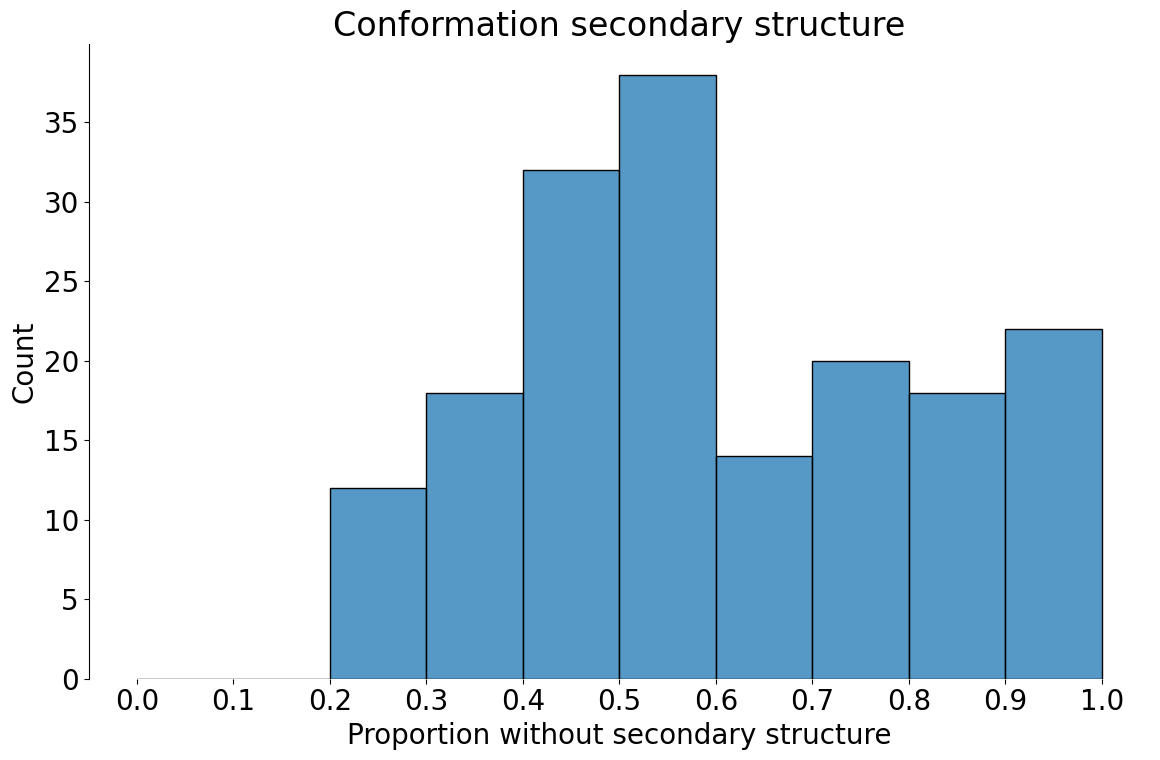

<Figure size 1200x800 with 0 Axes>

In [15]:
sns.histplot(data=grp,x="-_rel", binrange=(0,1),binwidth=0.1)
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.xlabel("Proportion without secondary structure")
plt.title("Conformation secondary structure")
plt.tight_layout()
plt.savefig("visualisations/conformation_secondary_structure.svg", format="svg", dpi=600, transparent=True)
plt.savefig("visualisations/conformation_secondary_structure.pdf", format="pdf", dpi=600, transparent=True)
plt.show()
plt.clf()

In [16]:
print(len(grp[~(grp["Fraction of lDDT ≥ 0.7"]) & (grp["-_rel"]<0.5)]))
grp[~(grp["Fraction of lDDT ≥ 0.7"]) & (grp["-_rel"]<0.5)]

4


,Model rank,Model number,lDDT,pLDDT,BB-lDDT,TM-score,inconsistent_residues,length,bad_bonds,bad_angles,MSA,Model,-_total,-_rel,Fraction of lDDT ≥ 0.7
struc,,,,,,,,,,,,,,,
1kctA,6,5,0.695,88.647857,0.776,0.792,"[A.269.-A.273., A.316.-A.320., A.335.-A.339.]",375,39,116,Synthetic,RoseTTAFold2,37,0.440476,False
2namA,6,5,0.570,97.944183,0.643,0.310,[A.4.-A.4.],153,63,171,Synthetic,RoseTTAFold2,36,0.235294,False
3o44A,6,5,0.644,90.740556,0.929,0.417,[],581,11,17,Synthetic,RoseTTAFold2,8,0.444444,False
5k5gA,6,5,0.314,96.256667,0.336,0.142,[],21,0,4,Synthetic,RoseTTAFold2,8,0.380952,False


In [17]:
print(len(grp[~(grp["Fraction of lDDT ≥ 0.7"]) & (grp["-_rel"]>=0.5)]))
grp[~(grp["Fraction of lDDT ≥ 0.7"]) & (grp["-_rel"]>=0.5)]

20


,Model rank,Model number,lDDT,pLDDT,BB-lDDT,TM-score,inconsistent_residues,length,bad_bonds,bad_angles,MSA,Model,-_total,-_rel,Fraction of lDDT ≥ 0.7
struc,,,,,,,,,,,,,,,
1mbyA,6,5,0.658,87.805625,0.693,0.553,[A.71.-A.65.],75,2,3,Synthetic,RoseTTAFold2,11,0.916667,False
1qlnA,6,5,0.363,90.775000,0.704,0.344,[],862,11,37,Synthetic,RoseTTAFold2,13,0.812500,False
1xtgB,6,5,0.597,98.747750,0.690,0.488,[],59,0,11,Synthetic,RoseTTAFold2,29,0.725000,False
2axzA,6,5,0.657,76.468571,0.723,0.843,"[A.292.-A.292., A.294.-A.294., A.295.-A.295., ...",300,1,7,Synthetic,RoseTTAFold2,11,0.846154,False
2jmrA,6,5,0.650,79.574800,0.782,0.367,[],179,3,12,Synthetic,RoseTTAFold2,25,1.000000,False
2k0qA,6,5,0.635,84.580870,0.807,0.373,[],74,2,11,Synthetic,RoseTTAFold2,18,0.782609,False
2lelA,6,5,0.541,91.473913,0.662,0.349,[],74,2,10,Synthetic,RoseTTAFold2,18,0.782609,False
2n0aD,6,5,0.588,80.804710,0.683,0.362,[],140,75,241,Synthetic,RoseTTAFold2,97,0.702899,False
2n54B,6,5,0.529,91.816471,0.705,0.275,[A.58.-A.59.],66,0,12,Synthetic,RoseTTAFold2,12,0.705882,False


## Analysis of exclusive matches

In [18]:
for name in scores.Model.unique():
    for seq in ["MMseqs2", "Synthetic"]:
        name_df = scores[(scores["Model"]==name)&(scores["MSA"]==seq)].groupby(["struc"]).agg("max")
        not_name = scores[(scores["Model"]!=name)|(scores["MSA"]!=seq)].groupby(["struc"]).agg("max")
        print(f"Unique structures for combination {name}, {seq} MSA: {len(set(name_df[name_df["Fraction of lDDT ≥ 0.7"]].index.unique()) -set(not_name[(not_name["Fraction of lDDT ≥ 0.7"])].index.unique()))} structures." )
        print(set(name_df[name_df["Fraction of lDDT ≥ 0.7"]].index.unique()) -set(not_name[(not_name["Fraction of lDDT ≥ 0.7"])].index.unique()))

Unique structures for combination AlphaFold2 Cluster, MMseqs2 MSA: 2 structures.
{'2lv1A', '1nqdA'}
Unique structures for combination AlphaFold2 Cluster, Synthetic MSA: 0 structures.
set()
Unique structures for combination AlphaFold 3, MMseqs2 MSA: 1 structures.
{'4ydqB'}
Unique structures for combination AlphaFold 3, Synthetic MSA: 7 structures.
{'5c3iF', '2lejA', '4aalA', '1mnmC', '4phqA', '3njqA', '1xjuB'}
Unique structures for combination AlphaFold 2, MMseqs2 MSA: 0 structures.
set()
Unique structures for combination AlphaFold 2, Synthetic MSA: 1 structures.
{'2a73B'}
Unique structures for combination Remote homologs, MMseqs2 MSA: 0 structures.
set()
Unique structures for combination Remote homologs, Synthetic MSA: 0 structures.
set()
Unique structures for combination RoseTTAFold2, MMseqs2 MSA: 0 structures.
set()
Unique structures for combination RoseTTAFold2, Synthetic MSA: 0 structures.
set()


In [19]:
no_clust = scores[scores["Model"]!="AlphaFold2 Cluster" ].groupby(["struc"]).agg("max")
print(set(no_clust[~(no_clust["Fraction of lDDT ≥ 0.7"])].index.unique())-set(grp[~(grp["Fraction of lDDT ≥ 0.7"])].index.unique()))

{'2lv1A', '1nqdA'}


In [20]:
name_df = scores[(scores["MSA"]=="MMseqs2")].groupby(["struc"]).agg("max")
not_name = scores[(scores["MSA"]!="MMseqs2")].groupby(["struc"]).agg("max")
not_in = set(name_df[name_df["Fraction of lDDT ≥ 0.7"]].index.unique()) -set(not_name[(not_name["Fraction of lDDT ≥ 0.7"])].index.unique())
print(f"Unique structures for MMseqs2 MSA: {len(not_in)} structures." )
print("Only synthetic MSA of those")
not_name[not_name.index.isin(not_in)]

Unique structures for MMseqs2 MSA: 4 structures.
Only synthetic MSA of those


,Model rank,Model number,lDDT,pLDDT,BB-lDDT,TM-score,inconsistent_residues,length,bad_bonds,bad_angles,MSA,Model,-_total,-_rel,Fraction of lDDT ≥ 0.7
struc,,,,,,,,,,,,,,,
1nqdA,6,5,0.631,89.636061,0.680,0.685,"[A.1.-A.1., A.2.-A.2., A.3.-A.3., A.4.-A.4., A...",111,0,3,Synthetic,RoseTTAFold2,16,0.500000,False
2kkwA,6,5,0.659,80.555362,0.733,0.369,[],140,61,170,Synthetic,RoseTTAFold2,38,0.275362,False
2lv1A,6,5,0.689,68.708000,0.746,0.255,[],147,1,11,Synthetic,RoseTTAFold2,15,1.000000,False
4ydqB,6,5,0.679,89.018421,0.794,0.697,"[A.82.-A.73., A.83.-A.74.]",478,2,6,Synthetic,RoseTTAFold2,6,0.157895,False


In [21]:
alli = scores.groupby(["struc"]).agg("max")
alli[alli.index.isin(not_in)]

,Model rank,Model number,lDDT,pLDDT,BB-lDDT,TM-score,inconsistent_residues,length,bad_bonds,bad_angles,MSA,Model,-_total,-_rel,Fraction of lDDT ≥ 0.7
struc,,,,,,,,,,,,,,,
1nqdA,6,5,0.720,89.636061,0.751,0.711,"[A.1.-A.1., A.2.-A.2., A.3.-A.3., A.4.-A.4., A...",111,7,43,Synthetic,RoseTTAFold2,16,0.500000,True
2kkwA,6,5,0.751,80.804710,0.873,0.401,[],140,65,203,Synthetic,RoseTTAFold2,97,0.702899,True
2lv1A,6,5,0.743,68.708000,0.858,0.512,[],147,1,13,Synthetic,RoseTTAFold2,15,1.000000,True
4ydqB,6,5,0.778,89.018421,0.857,0.807,"[A.82.-A.73., A.83.-A.74.]",478,26,80,Synthetic,RoseTTAFold2,12,0.315789,True


Where AF_Cluster is better can be explained with more seeds on rather IDR proteins.

4yqdB,1nqdA already had a high TM-score, so nothing too too interesting here
2lv1A has a lot of IDRs and was close.

2kkwA is the only one that interest me a bit more, but "SLAS-micelle bound alpha-synuclein" is both in a micelle and connected to prions and partially unfolded which makes it hard to reason about. Also, only 1 in 1000 calculated conformers was submitted?

## Look if there is one very good model of the 5 AlphaFold2/3 models
No, they all look the same &rightarrow; Supporting information.

/tmp/ipykernel_4091579/1199458718.py:8: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.violinplot(scores[scores.Model=="AlphaFold2 Cluster"].groupby(["struc","Model number", "MSA"]).agg("max"), x="Model number", y="lDDT", hue="MSA", split=True, inner="quart", palette=["#006400", "#90EE90"],cut=0, linewidth=3, ax=ax3)


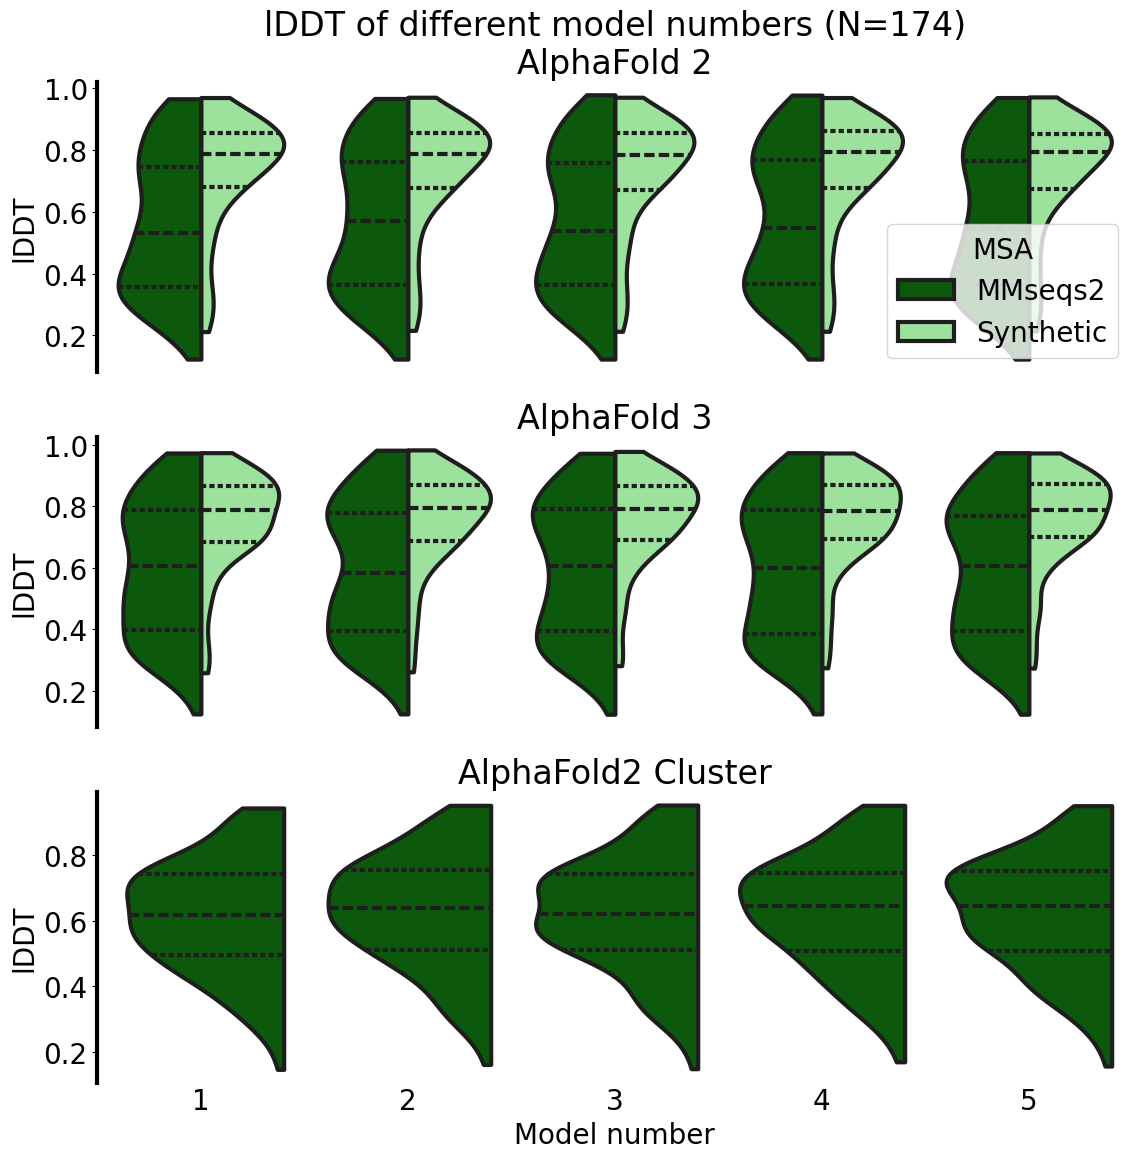

<Figure size 1200x1200 with 0 Axes>

In [22]:
plt.rcParams["figure.figsize"] = (12,12)

#Model
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)
sns.violinplot(scores[scores.Model=="AlphaFold 2"].groupby(["struc","Model number", "MSA"]).agg("max"), x="Model number", y="lDDT", hue="MSA", split=True, inner="quart", palette=["#006400", "#90EE90"],cut=0, linewidth=3, ax=ax1)
# 
sns.violinplot(scores[scores.Model=="AlphaFold 3"].groupby(["struc","Model number", "MSA"]).agg("max"), x="Model number", y="lDDT", hue="MSA", split=True, inner="quart", palette=["#006400", "#90EE90"],cut=0, linewidth=3, ax=ax2)
sns.violinplot(scores[scores.Model=="AlphaFold2 Cluster"].groupby(["struc","Model number", "MSA"]).agg("max"), x="Model number", y="lDDT", hue="MSA", split=True, inner="quart", palette=["#006400", "#90EE90"],cut=0, linewidth=3, ax=ax3)
handles = [mpatches.Patch(facecolor="#006400", label="MMseqs2"), mpatches.Patch(facecolor="#90EE90", label="Synthetic")]
plt.setp(ax1.spines.values(), linewidth=3)
plt.setp(ax2.spines.values(), linewidth=3)
plt.setp(ax3.spines.values(), linewidth=3)
ax1.tick_params(axis=u'x', which=u'both',length=0)
ax2.tick_params(axis=u'x', which=u'both',length=0)
ax2.get_legend().remove()
ax3.tick_params(axis=u'x', which=u'both',length=0)
ax3.get_legend().remove()
ax1.set_title(f"lDDT of different model numbers (N={len(set(all_strucs))})\nAlphaFold 2")
ax2.set_title("AlphaFold 3")
ax3.set_title("AlphaFold2 Cluster")
plt.tight_layout()
plt.savefig("visualisations/lDDT_model_number.svg", format="svg", dpi=600, transparent=True)
plt.savefig("visualisations/lDDT_model_number.pdf", format="pdf", dpi=600, transparent=True)
plt.show()
plt.clf()

/tmp/ipykernel_4091579/1147733106.py:5: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.violinplot(scores[scores.Model=="AlphaFold2 Cluster"].groupby(["struc","Model rank", "MSA"]).agg("max"), x="Model rank", y="lDDT", hue="MSA", split=True, inner="quart", palette=["#006400", "#90EE90"],cut=0, linewidth=3, ax=ax2)


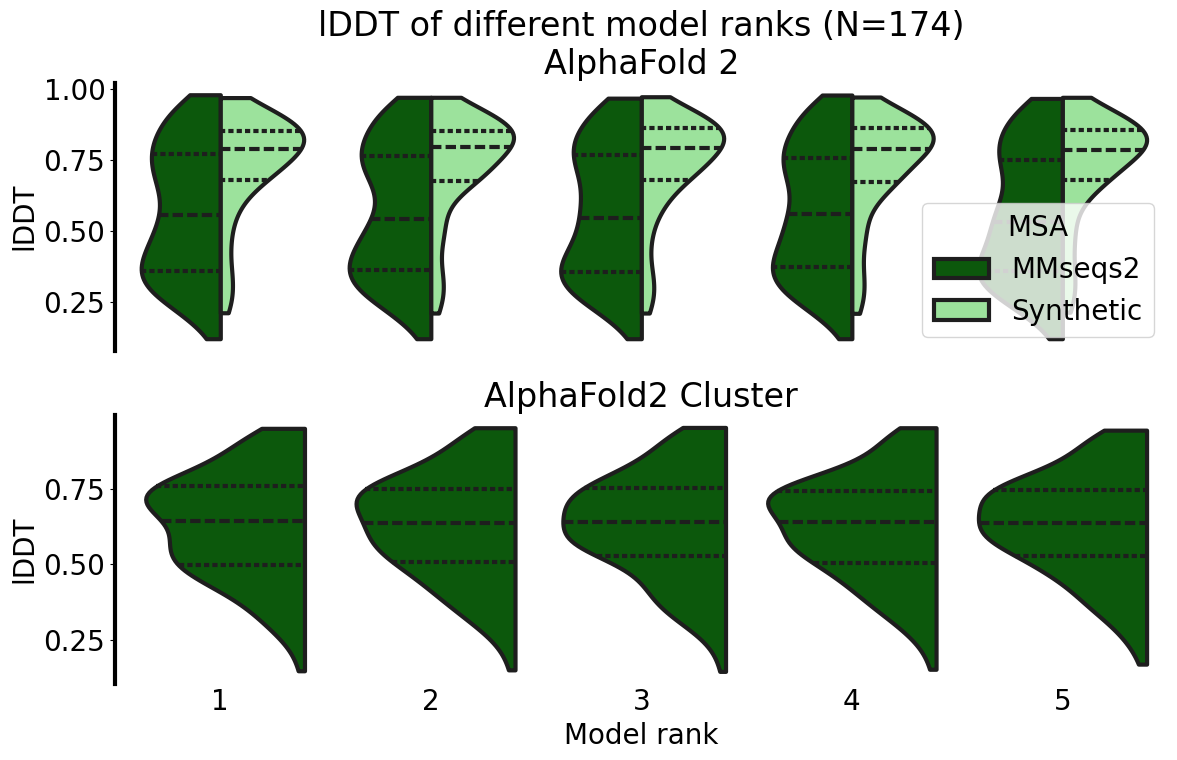

<Figure size 1200x800 with 0 Axes>

In [23]:
plt.rcParams["figure.figsize"] = (12,8)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
sns.violinplot(scores[scores.Model=="AlphaFold 2"].groupby(["struc","Model rank", "MSA"]).agg("max"), x="Model rank", y="lDDT", hue="MSA", split=True, inner="quart", palette=["#006400", "#90EE90"],cut=0, linewidth=3, ax=ax1)
sns.violinplot(scores[scores.Model=="AlphaFold2 Cluster"].groupby(["struc","Model rank", "MSA"]).agg("max"), x="Model rank", y="lDDT", hue="MSA", split=True, inner="quart", palette=["#006400", "#90EE90"],cut=0, linewidth=3, ax=ax2)
handles = [mpatches.Patch(facecolor="#006400", label="MMseqs2"), mpatches.Patch(facecolor="#90EE90", label="Synthetic")]
plt.setp(ax1.spines.values(), linewidth=3)
plt.setp(ax2.spines.values(), linewidth=3)
ax1.tick_params(axis=u'x', which=u'both',length=0)
ax2.tick_params(axis=u'x', which=u'both',length=0)
ax2.get_legend().remove()
ax1.set_title(f"lDDT of different model ranks (N={len(set(all_strucs))})\nAlphaFold 2")
ax2.set_title("AlphaFold2 Cluster")
plt.tight_layout()
plt.savefig("visualisations/lDDT_model_ranks.svg", format="svg", dpi=600, transparent=True)
plt.savefig("visualisations/lDDT_model_ranks.pdf", format="pdf", dpi=600, transparent=True)
plt.show()
plt.clf()